<a href="https://colab.research.google.com/github/Srividhyak2011/Demo-Datascienceproject/blob/main/M3_MP7_NB_Fraud_detection_for_mobile_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Intelligence
## A program by IIT Madras and TalentSprint
### Mini Project 07 : Fraud detection for mobile transactions


### Learning Objectives

At the end of the mini project, you will be able to understand-
 
* Perform EDA and visualise the data
* Perform grid search for best hyper-parameter
* Handling unbalanced data using SMOTE technique
* predict the fraud transactions using various ML classification algorithms



### Importing libraries

In [25]:
import os
import math
import operator
from numpy import * 
import numpy as np
import pandas as pd
import random
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization

from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # import GridSearchCV
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Description

Kaggle's Paysim dataset is used.PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

### **Dataset description** :

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
#@title Download Dataset
%%capture
!wget https://cdn.iisc.talentsprint.com/ADSMI/Datasets/fraud_in_mobile_payments.zip
!unzip "fraud_in_mobile_payments.zip"

### **Exercise 1**: Perform the following (2 points)

- Exploratory Data Analysis 
- Preprocessing 
- Visualisation of safe and fraud transactions
  - Plot the distribution of step vs safe and fraud transactions in the same window to compare their frequency
  - Scatter plot hourly fraud transactions

In [27]:
# Load data and check for null values and duplicate values
# YOUR CODE HERE
data = pd.read_csv('synthetic_mobile_transactions.csv') #, nrows=10000

data.shape

(6362620, 11)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [29]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [31]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [33]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [34]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [37]:
data.duplicated(keep='first').any()

False

In [18]:
data.drop_duplicates(keep='first', inplace=True)

In [19]:
data.shape

(10000, 11)

In [43]:
# Filter data by the labels. Safe and Fraud transaction
# YOUR CODE HERE

# Plot the frequency of the transactions for each class on the same plot.
# YOUR CODE HERE


In [39]:
safe = data[data['isFraud']==0] #Select * from abc where x=0 This will create separate dataframe named safe with isfraud = 0
fraud = data[data['isFraud']==1] #Select * from abc where x=0 This will create separate dataframe named fraud with isfraud = 1

In [40]:
safe.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


In [41]:
fraud.head() 

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


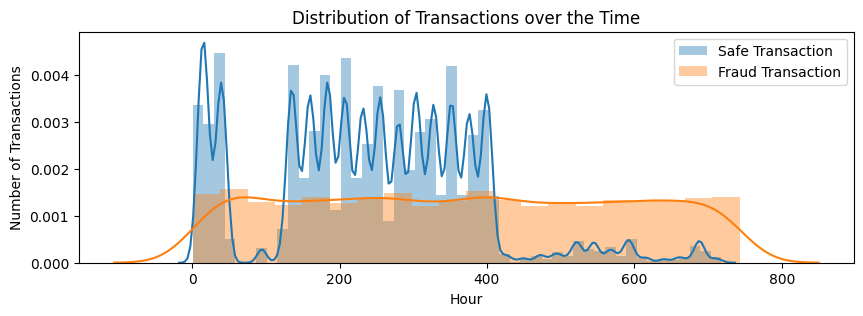

In [42]:
#See the frequency of the transactions for each class on the same plot.
plt.figure(figsize=(10, 3))
sns.distplot(safe.step, label="Safe Transaction")
sns.distplot(fraud.step, label='Fraud Transaction')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions over the Time')
plt.legend()

In [46]:
# Use small sample of data (say 1,00,000 points) to scatterplot the transaction happens every hour and their amount. 
smalldata=data.sample(n=100000, random_state=1)
smalldata=smalldata.sort_index()
smalldata=smalldata.reset_index(drop=True)

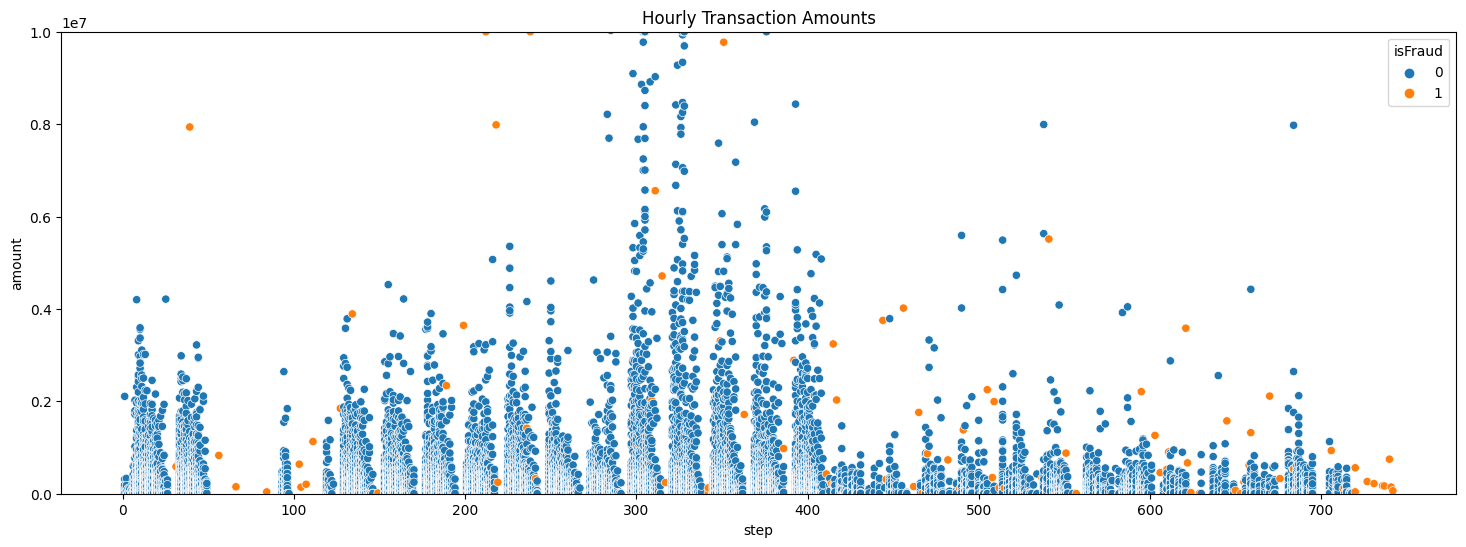

In [48]:
# Plot the hourly transaction amounts
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", hue="isFraud",
                     data=smalldata)

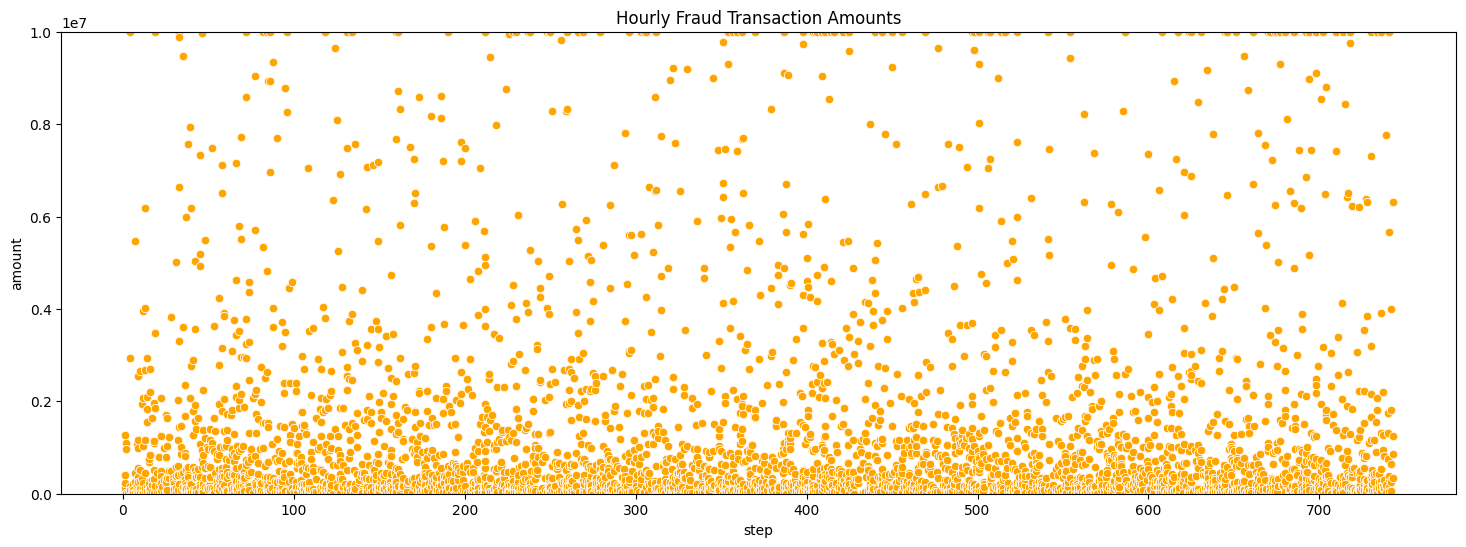

In [49]:
# Plot the hourly amount of all fraud transactions
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Fraud Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", color='orange',
                     data=fraud)

In [50]:
# Total of fraud transactions amount 
fraud.amount.value_counts()

10000000.00    287
0.00            16
1165187.89       4
429257.45        4
181.00           2
              ... 
149668.66        1
7316255.05       1
222048.71        1
9585040.37       1
234377.29        1
Name: amount, Length: 3977, dtype: int64

### **Exercise 2**: Understanding and sampling data points (1 point)

- Display count of fraud transactions 
  - CASH_OUT and TRANSFER are the fraud type transactions
  - Print proportion of fraud transactions
  - Total proportion of amount in fraud transactions

Dataset is huge. So for analysis we can sample the dataset say one lakh data points and analyse the data.

**nameOrig** and **nameDest** columns are supposed to be the names of the peeople. At this moment, they can not be used in machine learning model. 

- Drop the columns which are not useful in building machine learning model
- Convert the fraud transaction type **CASH_OUT** and **TRANSFER** using label encoding technique
- Split the sample the data into train and test sets 

In [53]:
# Checking type of fraud transactions
fraud.type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [ ]:
# Proportion of number of frauds 
# YOUR CODE HERE

In [ ]:
# Proportion of total sum fraud amount
# YOUR CODE HERE

In [ ]:
# Filtering only TRANSFER and CASH_OUT data
# YOUR CODE HERE

In [ ]:
# Sample data , get 100000 instances to train model
# YOUR CODE HERE

In [ ]:
#checking if there is any repetes transaction in between two parties.
# YOUR CODE HERE

In [ ]:
# Drop the name columns
# YOUR CODE HERE

In [ ]:
# Slice the target and features from the dataset and  split it into train and test set 
# YOUR CODE HERE

### **Exercise 3**: Training the model (2 points)

- Train the sample data in logistic regression and various other classification models
- Peform **grid search** for finding best hyper-parameters
- Plot classificartion report

In [ ]:
# Build a Logistic regression model and print scores
# YOUR CODE HERE

In [ ]:
# Grid Search for best parameters of RandomForestClassifier
# YOUR CODE HERE

In [ ]:
# Random forest classifier to train and evaluate a  model with given datasets 
# YOUR CODE HERE

Synthetic Minority Oversampling Technique **(SMOTE)** is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input. This implementation of SMOTE does not change the number of majority cases.

The new instances are not just copies of existing minority cases. Instead, the algorithm takes samples of the feature space for each target class and its nearest neighbours. The algorithm then generates new examples that combine features of the target case with features of its neighbours. This approach increases the features available to each class and makes the samples more general.

SMOTE takes the entire dataset as an input, but it increases the percentage of only the minority cases. For example, suppose you have an imbalanced dataset where just 1 percent of the cases have the target value A (the minority class), and 99 percent of the cases have the value B. To increase the percentage of minority cases to twice the previous percentage, you would enter 200 for SMOTE percentage in the component's properties.

### **Exercise 4**: SMOTE analysis (2 points)


- The dataset is imbalanced so SMOTE is used for dealing with imbalanced data
- Use `fit_resample()` method of SMOTE class to create balanced datasets 

In [ ]:
### Balancing Data via Oversampling with SMOTE

# YOUR CODE HERE

### **Exercise 5**: Training the model (2 points)

- Train the resampled data on various other classification models
- Plot classificartion report

In [ ]:
# Perform  train-test-split over resampled data
# YOUR CODE HERE

In [ ]:
#Imlement Random Forest classifier Model with resampled data
# YOUR CODE HERE

### **Exercise 6**: Feature importance (1 point)

- Plot the feature importance of all columns used in model building
- Use `feature_importances_` attribute of `RandomForestClassifier` class to get feature importance of columsn of dataset
- Plot Relative feature importance vs columns

In [ ]:
# Plot the feature importance 
# YOUR CODE HERE